# Activity Recognition in Video

A major part of this notebook has been taken from [this example in Keras](https://keras.io/examples/vision/video_classification/).

Some changes have been introduced such as using DeIT and ORB for feature extraction and a different method for sampling frames from the videos in the given dataset.

<mark style='background-color: yellow;'>This notebook just runs the model decribed in the aforementioned original notebook using **features extracted from the pre-trained InceptionNet V3 model** provided by Keras.</mark>

As in the original notebook we will be using a subset of the [UCF Activity Recognition dataset](https://www.crcv.ucf.edu/data/UCF101.php). We will not be modifying the hyperparameters except the *epoch* and *sampled sequence length* that may be increased. 

*The model configuration used here will be kept constant except obviously the input size.* 

This is because we want to compare the models built using CNN, ORB and DeIT.

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [2]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.9/dist-packages/tensorflow-2.12.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.12.0


In [3]:
!pip install tensorflow=='2.7.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 21.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [4]:
!pip install -q git+https://github.com/tensorflow/docs
!pip install transformers
!pip install gdown

  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 32.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data collection

In order to keep the runtime of this example relatively short, we will be using a
subsampled version of the original UCF101 dataset. You can refer to the notebook **dataset_subset_UCF.ipynb** in the repository to know how the subsampling was done.

The dataset is provided in the following link.
https://drive.google.com/file/d/1-1Jgmhg-84WbwZ8v9kvpFTDDpVUqRO1V/view?usp=share_link

In [5]:
!gdown 1-1Jgmhg-84WbwZ8v9kvpFTDDpVUqRO1V
!tar -xf /content/ucf101_top10.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1-1Jgmhg-84WbwZ8v9kvpFTDDpVUqRO1V
To: /content/ucf101_top10.tar.gz
100% 1.04G/1.04G [00:07<00:00, 138MB/s]


## Setup

In [6]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from tqdm import tqdm

import matplotlib.pyplot as plt

## Define hyperparameters



1.   IMG_SIZE - Required image size [IMG_SIZE, IMG_SIZE, 3]
2.   BATCH_SIZE - Number of inputs to train in a single iteration
3. EPOCHS - Number of training iterations
4. MAX_SEQ_LENGTH - Number of frames to be sampled from the image
5. NUM_FEATURES - The size of the feature vector extracted from the image or frame encoder (in this case its InceptionNet)



In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 50              

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## Data preparation

In [8]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 1171
Total videos for testing: 459


,video_name,tag
281,v_Drumming_g15_c07.avi,Drumming
710,v_PlayingGuitar_g10_c02.avi,PlayingGuitar
123,v_CricketShot_g09_c03.avi,CricketShot
696,v_PlayingDhol_g25_c06.avi,PlayingDhol
768,v_PlayingGuitar_g18_c04.avi,PlayingGuitar
893,v_Punch_g19_c04.avi,Punch
357,v_HorseRiding_g09_c04.avi,HorseRiding
988,v_ShavingBeard_g16_c03.avi,ShavingBeard
404,v_HorseRiding_g17_c01.avi,HorseRiding
1090,v_TennisSwing_g13_c03.avi,TennisSwing


We have used OpenCV's VideoCapture method to read each frame of the video.

As set by the corresponding hyperparameter, we will sample MAX_SEQ_LENGTH frames (denote by $M$ for now). To do this we first get the total number of frames (say, $F$) present in the video file using the metadata included in the read object created by the VideoCapture method.

Then we sample with step-size given by $⌊\frac{F}{M}⌋$ and stop once the number of sampled frames reaches $M$ (or maybe below it)

NOTE: The earlier implementation used to store all frames from all videos and then choose first MAX_SEQ_LENGTH frames to encode. We take the frames with the step-size mentioned above as this is equivalent and way more memory efficient.

In [9]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    F = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))    #total number of frames in the video
    M = max_frames                                #max sequence length required
    S = max(int(np.floor(F/M)), 1)                #in case step-size goes to 0

    frames = []
    frame_count = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count%S == 0:                #sample only at steps
              frame = crop_center_square(frame)
              frame = cv2.resize(frame, resize)
              frame = frame[:, :, [2, 1, 0]]
              frames.append(frame)

            frame_count += 1                      #update number of frames read
            
            #break if we reach end of video or maximum required frames read  
            if frame_count==F or len(frames) == M:         
                break
    finally:
        cap.release()
    return np.array(frames)


We can use a pre-trained network to extract meaningful features from the extracted
frames. The [`Keras Applications`](https://keras.io/api/applications/) module provides
a number of state-of-the-art models pre-trained on the [ImageNet-1k dataset](http://image-net.org/).
We will be using the [InceptionV3 model](https://arxiv.org/abs/1512.00567) for this purpose.

In [10]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 0s 0us/step


The labels of the videos are strings. Neural networks do not understand string values,
so they must be converted to some numerical form before they are fed to the model. Here
we will use the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer encode the class labels as integers.

In [11]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['BoxingPunchingBag', 'CricketShot', 'Drumming', 'HorseRiding', 'PlayingCello', 'PlayingDhol', 'PlayingGuitar', 'Punch', 'ShavingBeard', 'TennisSwing']


Finally, we can put all the pieces together to create our data processing utility.

In [12]:

def prepare_all_videos(df, root_dir, max_frames = 10):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(tqdm(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path), max_frames)
        frames = frames[None, ...]

#         # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            length = batch.shape[0]
            assert length == MAX_SEQ_LENGTH, "sequence length not sufficient!"
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose = 0
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [13]:
train_data, train_labels = prepare_all_videos(train_df, "train", max_frames=MAX_SEQ_LENGTH)
test_data, test_labels = prepare_all_videos(test_df, "test", max_frames=MAX_SEQ_LENGTH)

100%|██████████| 459/459 [10:21<00:00,  1.35s/it]


In [14]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (1171, 20, 2048)
Frame masks in train set: (1171, 20)


## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [15]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(128, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics='sparse_categorical_accuracy')
    
    return rnn_model


# Utility for running experiments.
def run_experiment(seq_model):

    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        epochs=EPOCHS
    )

    test_metrics = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f" {test_metrics}")

    return history, seq_model, test_metrics

In [16]:
model = get_sequence_model()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 128)      836352      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 128)      0           ['gru[0][0]']                

In [17]:
#fit model
training_hist, sequence_model, test_metrics = run_experiment(model)

Epoch 1/50
37/37 [==============================] - 8s 14ms/step - loss: 1.5274 - sparse_categorical_accuracy: 0.5611
Epoch 2/50
37/37 [==============================] - 1s 14ms/step - loss: 0.2697 - sparse_categorical_accuracy: 0.9838
Epoch 3/50
37/37 [==============================] - 1s 14ms/step - loss: 0.0546 - sparse_categorical_accuracy: 1.0000
Epoch 4/50
37/37 [==============================] - 1s 14ms/step - loss: 0.0242 - sparse_categorical_accuracy: 1.0000
Epoch 5/50
37/37 [==============================] - 1s 14ms/step - loss: 0.0147 - sparse_categorical_accuracy: 1.0000
Epoch 6/50
37/37 [==============================] - 1s 14ms/step - loss: 0.0104 - sparse_categorical_accuracy: 1.0000
Epoch 7/50
37/37 [==============================] - 1s 23ms/step - loss: 0.0075 - sparse_categorical_accuracy: 1.0000
Epoch 8/50
37/37 [==============================] - 1s 22ms/step - loss: 0.0054 - sparse_categorical_accuracy: 1.0000
Epoch 9/50
37/37 [==============================] - 1s 2

In [ ]:
#save model
model.save('activity_recog_cnn_gru')

In [ ]:
!tar -cf activity_recog_cnn_gru.tgz activity_recog_cnn_gru

In [ ]:
plt.plot(training_hist.history['loss'], label = 'training loss')
plt.plot(training_hist.history['sparse_categorical_accuracy'], label = 'training acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plot_txt = f"Test Accuracy: {round(test_metrics[-1], 3)}"
plt.text(30, 0.1, plot_txt, fontsize=8, backgroundcolor='lime')
plt.title('Training loss plot of CNN-GRU Approach')
plt.savefig('training_CNN_GRU_model.pdf')

## Inference

Test video path: v_HorseRiding_g03_c03.avi
(10,) [9.7403545e-06 1.9254267e-06 1.1719119e-05 9.9997151e-01 3.3017406e-07
 1.1746515e-06 1.1737793e-06 2.9057851e-08 1.2608945e-07 2.2968445e-06]
  HorseRiding: 100.00%
  Drumming:  0.00%
  BoxingPunchingBag:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%
  PlayingDhol:  0.00%
  PlayingGuitar:  0.00%
  PlayingCello:  0.00%
  ShavingBeard:  0.00%
  Punch:  0.00%



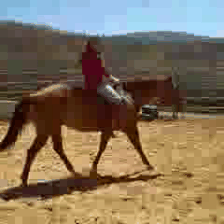

In [21]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        length = batch.shape[0]
        assert length == MAX_SEQ_LENGTH, "sequence length not sufficient!"
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path), max_frames=MAX_SEQ_LENGTH)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]
    print(probabilities.shape, probabilities)

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])